# **MIMIC**:
# Medical Information Mart for Intensive Care 




*   [Documenation](https://mimic.physionet.org)
*   Single center: Beth Israel Deaconess Medical Center
*   Detailed in-ICU information 
*   Limited out-ICU data
*   \>60,000 ICU stays and \>40,000 patients
*   **Real Data**



**Accessing the data**


*   *Colab*: Jupyter notebook environment, run queries, gather and process data.
*   [*BigQuery*](https://bigquery.cloud.google.com/): Run queries and explore data.



**Setting up Colab**

To query data using BigQuery you'll need to import some libraries. Just run the following cell:

In [0]:
# Imports required to access datathon data
from google.colab import auth
from google.cloud import bigquery
import os

# Feel free to import other libraries
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Authenticate yourself, follow the link to login with your gmail if requested and copy/paste the verification code:

In [0]:
auth.authenticate_user()

Finally link the notebook to BigQuery:

In [0]:
project_id='aarhus-critical-2019-team'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id


# Returns a dataframe given query string as input. 
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, configuration={'query':{'useLegacySql': False}}, dialect = 'legacy')

Let's run a query to show how to pull data:

In [0]:
example_query = '''
SELECT *
FROM `physionet-data.mimiciii_clinical.patients` p
LIMIT 100
'''

run_query(example_query).head(10)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,None,None,None,0
1,238,253,F,2089-11-26,None,None,None,0
2,242,258,F,2124-09-19,None,None,None,0
3,243,260,F,2105-03-23,None,None,None,0
4,247,264,F,2162-11-30,None,None,None,0
5,249,266,F,2090-12-17,None,None,None,0
6,250,267,F,2131-09-05,None,None,None,0
7,626,663,F,2086-05-12,None,None,None,0
8,630,667,F,2053-09-17,None,None,None,0
9,638,675,F,2158-04-05,None,None,None,0


Now let's try to compute the age at admission to the ICU using a simple join:

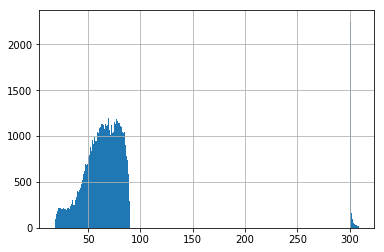

In [0]:
age_query = '''
SELECT i.icustay_id, p.gender, DATETIME_DIFF(i.intime, p.dob, YEAR) AS age 
FROM `physionet-data.mimiciii_clinical.icustays` i
INNER JOIN `physionet-data.mimiciii_clinical.patients` p
ON i.subject_id = p.subject_id'''

age_df = run_query(age_query)
age_df.age.hist(bins = np.arange(18, 310, 1))




Note that dates for patients older than 89 at admission were manipulated so to show them to be older than 300 for privacy reasons.

*You are good to go*

# **Predicting septic patients in-hospital mortality with physiological data**


Sepsis is a life threatening condition which requires prompt intervention from physicians and may lead to tissue damage, organ failure and potentially death.
It is estimated that 30 milion people worldwide are affected by sepsis and ,of those, 6 milions die from it. The incidence of sepsis rose significantly in the past decade and, in the U.S, accounts for 13% of healthcare expenditures[1][2].
Despite the relevance of Sepsis, an absolute consensus on its defintion has never been fully reached from the international community and several identification methods were proposed during the years, the most recent being Sepsis-3[3].

In this contest, the contribution that data analysis can provide has great clinical value, as it may spot patterns otherwise unseen. Most recently, it was shown how machine learning methods can suggest optimal treatmet in septic patients[4] or predict mortality in ICU[5]. 

The goal of this study is to assess wether it is possible to predict mortality of patients with angus sepsis using commonly measured vitals, scales and lab results in the first 48 hours of ICU from the MIMIC database.













**A: Cohort Definiton**

First, we want to define the cohort of patients. 
Particularly we are interested in those patients that:


*   Developed Angus sepsis.
*   Have age between 18 and 89.
*   Have stayed the ICU more than 48 hours.

At this point we may want to also extract features such as age, gender and in-hospital mortality, the latter one will be the outcome used to train our model. 

In [0]:
# hint: use the icustay_detail and angus_sepsis tables in the mimiciii_derived database

cohort_query = '''
SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admission_age, i.hospital_expire_flag, i.intime, i.icustay_seq
FROM `physionet-data.mimiciii_derived.icustay_detail` i
INNER JOIN `physionet-data.mimiciii_derived.angus_sepsis` a
ON a.hadm_id = i.hadm_id AND a.explicit_sepsis = 1
WHERE i.admission_age >= 18 AND i.admission_age < 89 AND i.los_icu >= 2
'''


cohort = run_query(cohort_query)

cohort = cohort.replace({'gender': {'F': 0, 
                                    'M': 1}})


cohort.head(10)

,subject_id,hadm_id,icustay_id,gender,admission_age,hospital_expire_flag,intime,icustay_seq
0,21,111970,216859,1,88,1,2135-01-30 20:53:34,1
1,38,185910,248910,1,76,0,2166-08-10 00:29:36,1
2,117,164853,217966,0,50,1,2133-11-18 13:24:19,1
3,124,138376,256064,1,76,1,2166-01-09 13:05:18,1
4,157,107880,264885,1,81,0,2106-06-17 19:51:46,1
5,191,136614,280149,1,73,0,2196-04-09 19:52:59,1
6,195,118936,291941,0,74,0,2167-12-02 13:16:56,1
7,195,118936,266038,0,74,0,2167-12-11 12:49:33,2
8,211,101148,248590,0,85,0,2197-12-17 02:53:02,1
9,223,105694,255617,1,68,0,2157-05-01 05:20:41,1


It is good practice to run some statistics to have an overview of the cohort:

In [0]:

cohort_stats = cohort.groupby('hospital_expire_flag').agg({'icustay_id': 'nunique', 'gender': 'mean', 'admission_age': ['mean', 'std']})
cohort_stats.loc['tot'] = cohort.agg({'icustay_id': 'nunique', 'gender': 'mean', 'admission_age': ['mean', 'std']}).stack().swaplevel()

cohort_stats


icustay_id    gender admission_age           
                        nunique      mean          mean        std
hospital_expire_flag                                              
0                        2282.0  0.564417     63.906661  15.177008
1                        1324.0  0.597432     66.434290  14.209354
tot                      3606.0  0.576539     64.834720  14.877060

**B: Querying vitals**

Most charted observations can be found in the chartevents table, like the vital parameters we need. The chartevents table is the largest in the MIMIC and contains many important variables like blood pressure readings, heart rate and respiration. 
We are now interested in:


*   Systolic blood pressure
*   Diastolic blood pressure
*   Heart rate 
*   Respiratory rate 
*   Temperature
*   Oxygen saturation (SpO2)

We want to query these variables for all patients defined in the cohort, but only for the first 48 hours. Be very carefull with units, as temperature for example is measured in both Celsius and Fahrenheit.

In [0]:
# Use the table `physionet-data.mimiciii_clinical.chartevents`
# hint: use table d_items and SQL function LIKE to find variables.
# hint: to keep only observations from the first 48 hours use the function DATETIME_DIFF with ICU intime.


vitals_query = '''
WITH cohort AS(
SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admission_age, i.hospital_expire_flag, i.intime
FROM `physionet-data.mimiciii_derived.icustay_detail` i
INNER JOIN `physionet-data.mimiciii_derived.angus_sepsis` a
ON a.hadm_id = i.hadm_id AND a.explicit_sepsis = 1
WHERE i.admission_age >= 18 AND i.admission_age < 89 AND i.los_icu >= 2
)
, vitals AS(
SELECT c.subject_id, c.hadm_id, c.icustay_id, c.charttime, DATETIME_DIFF(c.charttime, i.intime, MINUTE)/60 AS delta, 
CASE 
  WHEN c.itemid IN (223761, 678, 679) THEN (c.valuenum - 32)*(5/9) ELSE c.valuenum END AS valuenum, 
CASE 
	WHEN c.itemid IN (51, 442, 455, 6701, 220179, 220050)         THEN 'SBP'
  WHEN c.itemid IN (8368, 8440, 8441, 8555, 220180, 220051)     THEN 'DBP'
  WHEN c.itemid IN (618, 615, 220210, 224690)                   THEN 'RSP'
  WHEN c.itemid IN (223762, 676, 223761, 678, 677, 679)         THEN 'TMP'
  WHEN c.itemid IN (211, 220045)                                THEN 'HR'
  WHEN c.itemid IN (646, 22027)                                 THEN 'SpO2'
  ELSE NULL
  END AS type
FROM `physionet-data.mimiciii_clinical.chartevents` c
INNER JOIN cohort i
ON i.icustay_id = c.icustay_id 
WHERE DATETIME_DIFF(c.charttime, i.intime, MINUTE)/60 <= 48
ORDER BY c.subject_id, c.hadm_id, c.icustay_id, c.charttime)
SELECT *
FROM vitals v
WHERE v.type IS NOT NULL
'''

vitals = run_query(vitals_query)
vitals.head(10)

,subject_id,hadm_id,icustay_id,charttime,delta,valuenum,type
0,21,111970,216859,2135-01-30 22:00:00,1.116667,79.000000,HR
1,21,111970,216859,2135-01-30 22:00:00,1.116667,60.000000,DBP
2,21,111970,216859,2135-01-30 22:00:00,1.116667,114.000000,SBP
3,21,111970,216859,2135-01-30 22:00:00,1.116667,37.611099,TMP
4,21,111970,216859,2135-01-30 22:00:00,1.116667,37.611109,TMP
5,21,111970,216859,2135-01-30 22:00:00,1.116667,12.000000,RSP
6,21,111970,216859,2135-01-30 22:00:00,1.116667,98.000000,SpO2
7,21,111970,216859,2135-01-30 23:00:00,2.116667,100.000000,SpO2
8,21,111970,216859,2135-01-30 23:00:00,2.116667,75.000000,HR
9,21,111970,216859,2135-01-30 23:00:00,2.116667,82.000000,SBP


How to add Mean Arterial Pressure (MAP) to the above query?

**C: Lab results**

Lab test are another source with which it is possible to the describe physiological state of patients. Similarly for vitals, we want to extract all variables form the pivoted_lab table in the MIMIC derived database. 

In [0]:
# hint: lab tests are not associated to the icustay_id but to the hadm_id, filter values based on ICU admission time (intime)

lab_query = '''
WITH cohort AS(
SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admission_age, i.hospital_expire_flag, i.intime
FROM `physionet-data.mimiciii_derived.icustay_detail` i
INNER JOIN `physionet-data.mimiciii_derived.angus_sepsis` a
ON a.hadm_id = i.hadm_id AND a.explicit_sepsis = 1
WHERE i.admission_age >= 18 AND i.admission_age < 89 AND i.los_icu >= 2
)
SELECT l.*, DATETIME_DIFF(l.charttime, i.intime, MINUTE)/60 AS delta, i.icustay_id
FROM `physionet-data.mimiciii_derived.pivoted_lab` l
INNER JOIN cohort i 
ON i.hadm_id = l.hadm_id 
WHERE DATETIME_DIFF(l.charttime, i.intime, MINUTE)/60 >= -6 AND DATETIME_DIFF(l.charttime, i.intime, MINUTE)/60 <= 48
ORDER BY l.subject_id, l.hadm_id, i.icustay_id, l.charttime
'''

lab = run_query(lab_query)
lab.head(10)

,subject_id,hadm_id,charttime,ANIONGAP,ALBUMIN,BANDS,BICARBONATE,BILIRUBIN,CREATININE,CHLORIDE,GLUCOSE,HEMATOCRIT,HEMOGLOBIN,LACTATE,PLATELET,POTASSIUM,PTT,INR,PT,SODIUM,BUN,WBC,delta,icustay_id
0,21,111970,2135-01-30 19:05:00,19.0,NaN,1.0,23.0,NaN,4.2,99.0,200.0,29.6,9.1,NaN,275.0,3.8,31.7,1.7,18.1,137.0,49.0,30.5,-1.800000,216859
1,21,111970,2135-01-30 19:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.583333,216859
2,21,111970,2135-01-31 05:20:00,15.0,2.1,NaN,24.0,0.3,4.2,104.0,178.0,30.6,9.3,NaN,432.0,3.4,43.5,1.8,19.1,140.0,50.0,41.2,8.450000,216859
3,21,111970,2135-02-01 02:59:00,19.0,NaN,NaN,20.0,0.2,4.7,105.0,178.0,33.5,9.7,NaN,387.0,4.6,NaN,NaN,NaN,139.0,63.0,38.6,30.100000,216859
4,21,111970,2135-02-01 12:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.816667,216859
5,21,111970,2135-02-01 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.116667,216859
6,38,185910,2166-08-10 00:17:00,17.0,2.7,NaN,21.0,1.3,1.8,106.0,94.0,36.0,12.5,NaN,76.0,4.4,28.2,1.4,14.4,140.0,42.0,18.2,-0.200000,248910
7,38,185910,2166-08-10 16:13:00,16.0,NaN,NaN,20.0,NaN,2.6,107.0,137.0,NaN,NaN,NaN,NaN,4.2,50.6,1.7,15.6,139.0,55.0,NaN,15.733333,248910
8,38,185910,2166-08-11 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.533333,248910
9,38,185910,2166-08-11 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.2,NaN,NaN,NaN,NaN,NaN,25.016667,248910


How often are lab values measured? 
does the frequency of measurement correlate with the outcome?

**D: Glasgow Coma Scale**

The Galsgow Coma Scale (GCS) provides the state of a person's consciousness. The GCS is the combination of three indicators:


*   GCS Motor
*   GCS Verbal
*   GCS Eyes

We may query those too.


In [0]:
# hint: use the pivoted_gcs in mimiciii_derived

gcs_query = '''
WITH cohort AS(
SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admission_age, i.hospital_expire_flag, i.intime
FROM `physionet-data.mimiciii_derived.icustay_detail` i
INNER JOIN `physionet-data.mimiciii_derived.angus_sepsis` a
ON a.hadm_id = i.hadm_id AND a.explicit_sepsis = 1
WHERE i.admission_age >= 18 AND i.admission_age < 89 AND i.los_icu >= 2
)
SELECT l.*, i.subject_id, i.hadm_id, DATETIME_DIFF(l.charttime, i.intime, MINUTE)/60 AS delta
FROM `physionet-data.mimiciii_derived.pivoted_gcs` l
INNER JOIN cohort i 
ON i.icustay_id = l.icustay_id 
WHERE DATETIME_DIFF(l.charttime, i.intime, MINUTE)/60 >= -6 AND DATETIME_DIFF(l.charttime, i.intime, MINUTE)/60 <= 48
ORDER BY i.subject_id, i.hadm_id, i.icustay_id, l.charttime'''

gcs = run_query(gcs_query)
gcs.head(10)

,icustay_id,charttime,GCS,GCSMotor,GCSVerbal,GCSEyes,EndoTrachFlag,subject_id,hadm_id,delta
0,216859,2135-01-30 22:00:00,14.0,6.0,4.0,4.0,0,21,111970,1.116667
1,216859,2135-01-31 06:00:00,13.0,6.0,4.0,3.0,0,21,111970,9.116667
2,216859,2135-01-31 08:00:00,13.0,6.0,4.0,3.0,0,21,111970,11.116667
3,216859,2135-01-31 10:30:00,13.0,5.0,5.0,3.0,0,21,111970,13.616667
4,216859,2135-01-31 12:00:00,14.0,6.0,5.0,3.0,0,21,111970,15.116667
5,216859,2135-01-31 16:00:00,14.0,6.0,5.0,3.0,0,21,111970,19.116667
6,216859,2135-01-31 20:00:00,14.0,6.0,5.0,3.0,0,21,111970,23.116667
7,216859,2135-02-01 00:00:00,15.0,6.0,5.0,4.0,0,21,111970,27.116667
8,216859,2135-02-01 04:00:00,15.0,6.0,5.0,4.0,0,21,111970,31.116667
9,216859,2135-02-01 08:00:00,15.0,6.0,5.0,4.0,0,21,111970,35.116667


**E: Building the dataset**

Vitals data are structured differently from lab and gcs data (both pivoted). We want to merge everything together so that the end result matains the structure of gcs and lab. One approach to do this is to first stack the pivoted tables, gcs and lab. Now, vitals, gcs and lab share the same format. Leveraging pandas, we can use dataframes concatenation with pivoting to obtain the final dataset. 


In [0]:
p_gcs = gcs.set_index(['subject_id','hadm_id','icustay_id','charttime','delta']).stack().reset_index().rename({0: 'valuenum', 'level_5': 'type'}, axis = 1) # stacking the gcs table 
p_lab = lab.set_index(['subject_id','hadm_id','icustay_id','charttime','delta']).stack().reset_index().rename({0: 'valuenum', 'level_5': 'type'}, axis = 1) # stacking lab 

t0 = pd.concat([vitals, p_gcs, p_lab], axis = 0, sort = True) # now that gcs and lab have the same format as vitals, we can concatenate the theree tables along the rows.
ts_df = pd.pivot_table(t0, index = ['icustay_id', 'delta'], values = 'valuenum', columns = 'type') # applying the pivot operator.
ts_df = ts_df.reset_index()
ts_df['MAP'] = (ts_df['SBP'] + 2*ts_df['DBP'])/3 # combining features in this format is far easier, for example we can compute the mean arterial pressure easily.
ts_df.head(10)

type,icustay_id,delta,ALBUMIN,ANIONGAP,BANDS,BICARBONATE,BILIRUBIN,BUN,CHLORIDE,CREATININE,DBP,EndoTrachFlag,GCS,GCSEyes,GCSMotor,GCSVerbal,GLUCOSE,HEMATOCRIT,HEMOGLOBIN,HR,INR,LACTATE,PLATELET,POTASSIUM,PT,PTT,RSP,SBP,SODIUM,SpO2,TMP,WBC,MAP
0,200030,-5.166667,NaN,25.0,8.0,16.0,3.6,40.0,93.0,1.9,NaN,NaN,NaN,NaN,NaN,NaN,524.0,34.5,11.4,NaN,NaN,NaN,142.0,4.2,NaN,NaN,NaN,NaN,130.0,NaN,NaN,9.4,NaN
1,200030,-4.983333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200030,-4.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200030,-3.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,NaN,NaN,NaN,16.6,28.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200030,-2.466667,NaN,21.0,NaN,15.0,NaN,39.0,98.0,1.8,NaN,NaN,NaN,NaN,NaN,NaN,403.0,NaN,NaN,NaN,NaN,NaN,NaN,4.3,NaN,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN
5,200030,-2.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,200030,-0.883333,NaN,17.0,3.0,15.0,NaN,36.0,104.0,1.4,NaN,NaN,NaN,NaN,NaN,NaN,363.0,29.6,9.8,NaN,2.0,NaN,139.0,3.4,16.9,30.0,NaN,NaN,133.0,NaN,NaN,11.7,NaN
7,200030,-0.450000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,200030,-0.383333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,NaN,92.0,36.111105,NaN,84.333333
9,200030,-0.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,98.0,NaN,93.0,NaN,NaN,76.000000


We can verify the results by plotting some timeseries for a patient.

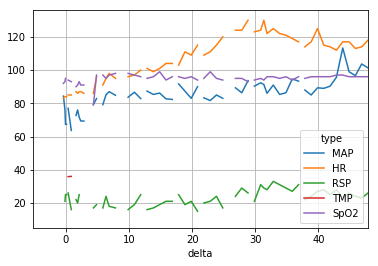

In [0]:
ts_df.loc[ts_df.icustay_id == 200030, ['delta','MAP', 'HR', 'RSP','TMP','SpO2']].plot(x = 'delta', grid = {'alpha': .3})

**F: Feature engineering**

To begin, let's keep it simple and just compute the mean and standard deviation of every variable as features. After computing the mean we should add the outcome (hospital_expire_flag), age and gender back to out dataset.

In [0]:
ds = ts_df.drop('delta', axis = 1).groupby('icustay_id').agg(['mean','std']) 
ds = ds.merge(cohort[['icustay_id', 'admission_age', 'gender','hospital_expire_flag']], on = 'icustay_id').rename({'hospital_expire_flag': 'outcome'}, axis = 1).set_index('icustay_id')

ds.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(ALBUMIN, mean)","(ALBUMIN, std)","(ANIONGAP, mean)","(ANIONGAP, std)","(BANDS, mean)","(BANDS, std)","(BICARBONATE, mean)","(BICARBONATE, std)","(BILIRUBIN, mean)","(BILIRUBIN, std)","(BUN, mean)","(BUN, std)","(CHLORIDE, mean)","(CHLORIDE, std)","(CREATININE, mean)","(CREATININE, std)","(DBP, mean)","(DBP, std)","(EndoTrachFlag, mean)","(EndoTrachFlag, std)","(GCS, mean)","(GCS, std)","(GCSEyes, mean)","(GCSEyes, std)","(GCSMotor, mean)","(GCSMotor, std)","(GCSVerbal, mean)","(GCSVerbal, std)","(GLUCOSE, mean)","(GLUCOSE, std)","(HEMATOCRIT, mean)","(HEMATOCRIT, std)","(HEMOGLOBIN, mean)","(HEMOGLOBIN, std)","(HR, mean)","(HR, std)","(INR, mean)","(INR, std)","(LACTATE, mean)","(LACTATE, std)","(PLATELET, mean)","(PLATELET, std)","(POTASSIUM, mean)","(POTASSIUM, std)","(PT, mean)","(PT, std)","(PTT, mean)","(PTT, std)","(RSP, mean)","(RSP, std)","(SBP, mean)","(SBP, std)","(SODIUM, mean)","(SODIUM, std)","(SpO2, mean)","(SpO2, std)","(TMP, mean)","(TMP, std)","(WBC, mean)","(WBC, std)","(MAP, mean)","(MAP, std)",admission_age,gender,outcome
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200030,NaN,NaN,17.571429,4.157609,5.500000,3.535534,17.000000,1.632993,3.600000,NaN,32.000000,7.238784,104.571429,6.948792,1.316667,0.453505,66.042373,7.609142,0.0,0.0,14.785714,0.578934,3.857143,0.363137,6.000000,0.000000,4.928571,0.267261,288.000000,160.031247,30.416667,2.394508,10.220000,0.875785,106.033898,14.534105,1.780000,0.164317,3.105882,1.732942,159.400000,17.728508,3.557143,0.571131,16.100000,0.667083,28.740000,1.594679,22.877193,4.799815,123.669492,14.526614,135.714286,4.785892,94.913793,2.842562,36.777782,0.787947,12.380000,1.907092,85.251412,9.394829,54,1,0
200036,NaN,NaN,13.000000,2.000000,NaN,NaN,23.333333,4.509250,NaN,NaN,49.666667,20.744477,113.333333,3.511885,1.566667,0.665833,75.081081,13.064750,0.0,0.0,11.333333,3.446562,3.333333,1.154701,5.000000,1.348400,3.000000,1.348400,178.000000,151.792622,37.300000,5.367495,12.533333,1.975686,106.244898,14.706193,1.350000,0.070711,2.100000,NaN,154.000000,25.534291,3.933333,0.838650,15.250000,0.636396,37.300000,9.758074,21.979167,3.900298,118.027027,17.147216,145.666667,8.082904,98.977778,1.453661,36.273506,0.205960,7.666667,2.494661,89.396396,13.384125,75,1,0
200063,NaN,NaN,13.250000,2.872281,NaN,NaN,23.750000,2.986079,NaN,NaN,12.000000,1.825742,106.750000,2.217356,1.275000,0.330404,52.716418,5.224668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.333333,16.165808,27.320000,0.965401,9.525000,0.386221,91.984848,4.925577,1.166667,0.115470,2.283333,1.322750,171.750000,39.373214,4.225000,0.450000,13.733333,0.929157,31.833333,4.101626,16.891304,3.881394,111.119403,9.217116,139.250000,2.500000,NaN,NaN,37.888889,0.505118,7.525000,1.887459,72.184080,5.798317,37,1,0
200065,2.25,0.777817,24.500000,3.849439,23.333333,9.451631,17.166667,5.166911,1.450000,0.645497,28.333333,6.414945,102.583333,5.071459,3.000000,0.612001,81.180328,10.788123,1.0,0.0,3.769231,1.877669,1.153846,0.375534,1.615385,1.502135,1.000000,0.000000,212.333333,68.063250,24.754545,2.055901,8.180000,0.614275,109.016393,14.606496,2.525000,1.019454,11.005000,2.611206,29.600000,23.716848,4.400000,0.718584,19.175000,3.918363,46.100000,20.122624,34.523810,5.679923,119.983607,22.596085,140.083333,2.020726,97.966667,2.603561,36.746918,1.668901,41.190000,6.842587,94.114754,14.270649,45,0,0
200075,2.70,0.282843,15.500000,0.707107,NaN,NaN,16.333333,1.154701,4.000000,1.272792,12.000000,3.000000,108.000000,1.632993,0.733333,0.152753,56.000000,14.048158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.666667,21.079216,31.166667,1.665333,11.000000,0.529150,80.180328,9.427810,1.275000,0.095743,1.680000,0.342053,124.666667,19.295941,3.725000,0.788987,14.575000,1.325079,66.033333,28.446769,21.438596,3.802103,114.639706,22.131534,136.250000,2.986079,NaN,NaN,36.459596,0.404520,23.550000,10.111627,75.546569,16.124049,83,0,0
200087,NaN,NaN,10.000000,2.000000,6.666667,4.932883,23.333333,1.154701,0.700000,NaN,33.666667,2.516611,

How to expand the features space beside mean and stadard deviaton? 

**G: Modeling**

Once the dataset is ready we can attempt a simple classification. 

In [0]:
# useful libraries

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.metrics as mtr

In [0]:
# useful functions


# Plots roc curve
def plot_roc(y_true, y_proba, pos_class = 1):
  fpr, tpr, _ = mtr.roc_curve(y_true, y_proba[:,pos_class])
  auc = mtr.auc(fpr, tpr)
  
  fig, ax = plt.subplots()
  ax.plot(fpr, tpr)
  ax.plot([0,1], [0, 1], color = 'k', linestyle = '--', alpha = .3)
  ax.text(.5, .5, 'AUC: {:.2f}'.format(auc), fontweight = 'bold', ha = 'center')
  
  ax.grid(alpha = .3)
  ax.set_xlim([0,1])
  ax.set_ylim([0,1])
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')
  
  
  


In [0]:
# Split train and test set in  75%/25% 

X, y = ds.drop('outcome', axis = 1), ds.outcome
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = .25, stratify = y)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


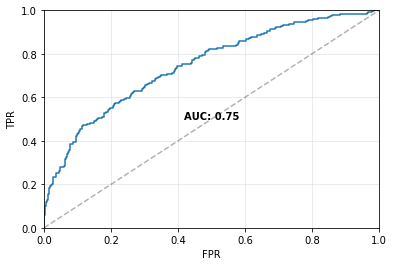

In [0]:
# Logistic Regression 

clf_lr = Pipeline([
    ('si', SimpleImputer()),
    ('sd', StandardScaler()),
    ('lr', LogisticRegression(random_state = 0))
])

clf_lr.fit(X_train, y_train)
y_prob = clf_lr.predict_proba(X_test)
plot_roc(y_test, y_prob)

In [0]:
y_pred = clf_lr.predict(X_test)
print(mtr.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       571
           1       0.65      0.48      0.56       331

    accuracy                           0.72       902
   macro avg       0.70      0.67      0.67       902
weighted avg       0.71      0.72      0.70       902



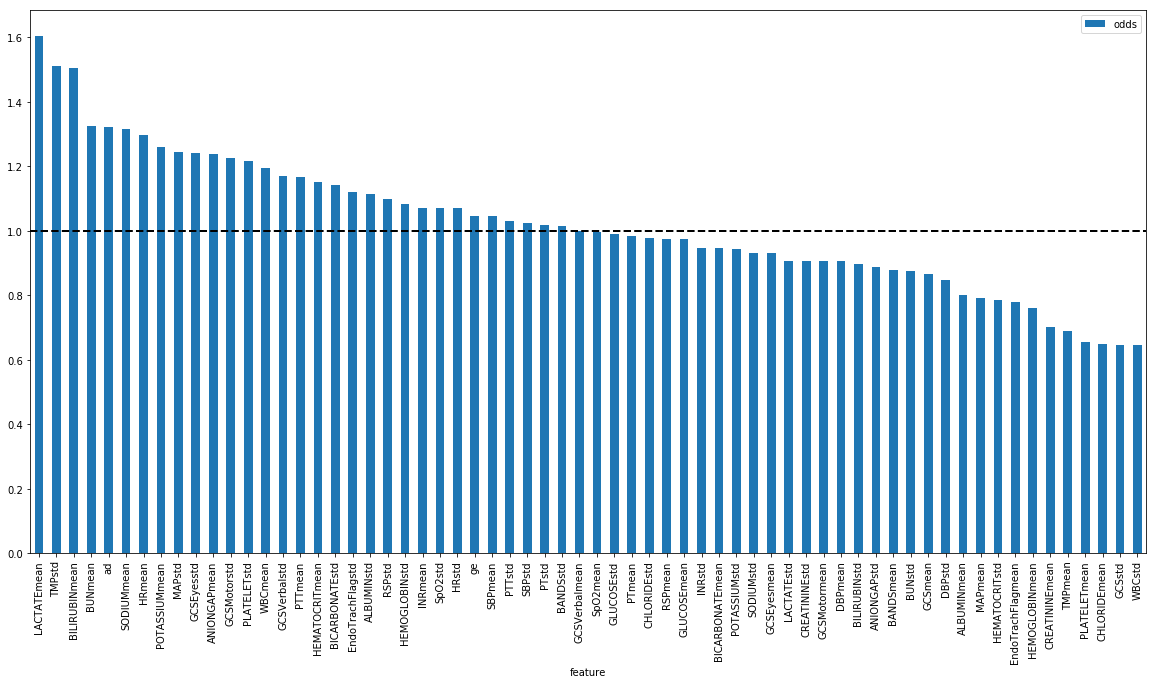

In [0]:
odds = np.exp(clf_lr.steps[2][1].coef_)

feat_names = [val[0] + val[1] for val in ds.drop('outcome', axis = 1).columns]
feat_df = pd.DataFrame({'feature': feat_names, 'odds': odds[0]}).sort_values(by = 'odds', ascending = False)

fig, ax = plt.subplots(figsize = (20, 10))
feat_df.plot.bar(x = 'feature', ax = ax)
ax.plot(ax.get_xlim(), [1,1], color = 'k', linestyle = '--', linewidth = 2)

* Does this model overfit?
* Are features all indipendent?
* Would feature selection improve perfromance?


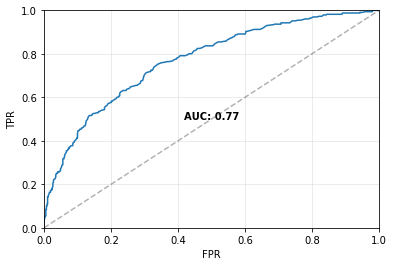

In [0]:
# Random Forest

clf_rf = Pipeline([
    ('si', SimpleImputer()),
    ('rf', RandomForestClassifier(random_state = 0))
])

random_param = {
    'rf__n_estimators': np.arange(100, 1000, 100),
    'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__min_samples_split': [2, 5, 10]
}

rs = RandomizedSearchCV(clf_rf, random_param, random_state = 0, cv = 10, 
                        n_iter = 10, n_jobs = -1)
rs.fit(X_train, y_train)
y_prob = rs.best_estimator_.predict_proba(X_test)
plot_roc(y_test, y_prob)


In [0]:
y_pred = rs.best_estimator_.predict(X_test)
print(mtr.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.90      0.80       571
           1       0.71      0.41      0.52       331

    accuracy                           0.72       902
   macro avg       0.72      0.66      0.66       902
weighted avg       0.72      0.72      0.70       902



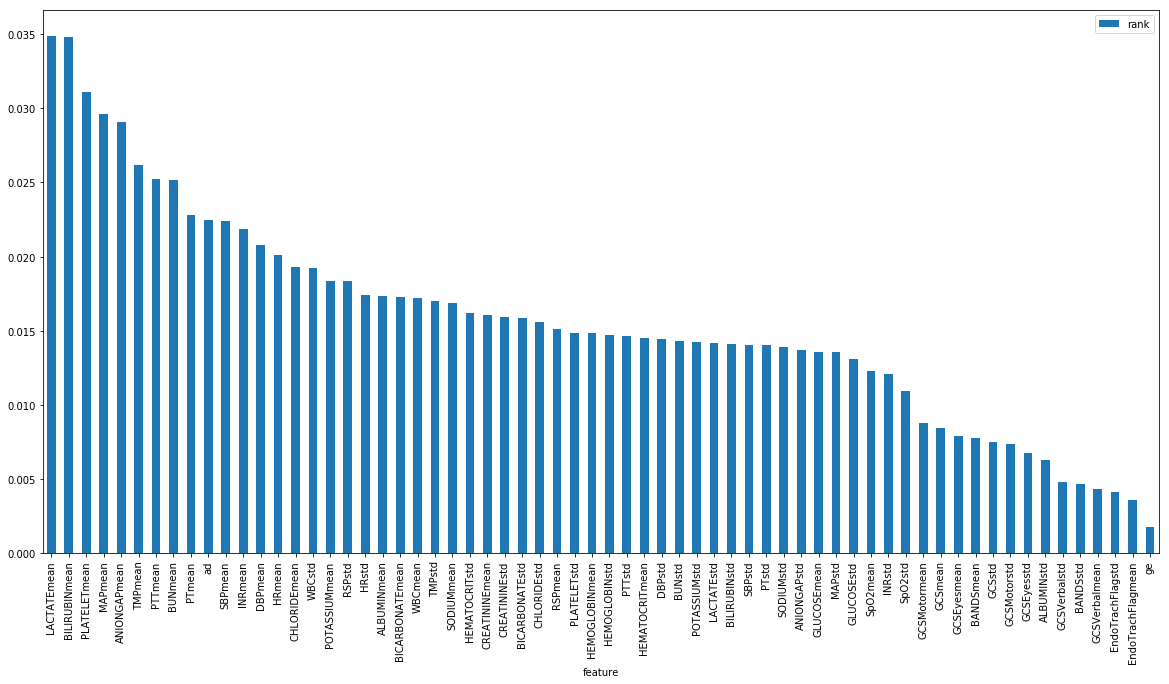

In [0]:
rank = rs.best_estimator_.steps[1][1].feature_importances_
rf_rank = pd.DataFrame({'feature': feat_names, 'rank': rank}).sort_values(by = 'rank', ascending = False)


fig, ax = plt.subplots(figsize = (20, 10))
rf_rank.plot.bar(x = 'feature', ax = ax)

* Is random forest overfitting?
* How does it compare to gradient boosting?

[1] Early Prediction of Sepsis from Clinical Data -- the PhysioNet Computing in Cardiology Challenge 2019, M Reyna et al 

[2] Vincent, Jean-Louis, et al. "Sepsis definitions: time for change." Lancet (London, England) 381.9868 (2013): 774.

[3] Singer, Mervyn, et al. "The third international consensus definitions for sepsis and septic shock (Sepsis-3)." Jama 315.8 (2016): 801-810.

[4] Komorowski, Matthieu, et al. "The Artificial Intelligence Clinician learns optimal treatment strategies for sepsis in intensive care." Nature Medicine 24.11 (2018): 1716.

[5] Pirracchio, Romain, et al. "Mortality prediction in intensive care units with the Super ICU Learner Algorithm (SICULA): a population-based study." The Lancet Respiratory Medicine 3.1 (2015): 42-52